In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import pickle

In [8]:
df = pd.read_csv("data/cf_train_no_noise.csv")
df_noise = pd.read_csv("data/cf_train.csv")
test_df = pd.read_csv("data/cf_test_no_noise.csv")
test_df_noise = pd.read_csv("data/cf_test.csv")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
def encode(value, encoding):
    for key, val in encoding.items():
        if value == key:
            return val

class_values_era = list(df.era.unique())
class_values_era.sort()
class_values_target = list(df.target_10_val.unique())
class_values_target.sort()
era_encoding = {val: i for i, val in enumerate(class_values_era)}
target_encoding = {val: i for i, val in enumerate(class_values_target)}
df["era"] = df["era"].apply(encode, args=(era_encoding,))
df["target_5_val"] = df["target_5_val"].apply(encode, args=(target_encoding,))
df["target_10_val"] = df["target_10_val"].apply(encode, args=(target_encoding,))

df_noise["era"] = df_noise["era"].apply(encode, args=(era_encoding,))
df_noise["target_5_val"] = df_noise["target_5_val"].apply(encode, args=(target_encoding,))
df_noise["target_10_val"] = df_noise["target_10_val"].apply(encode, args=(target_encoding,))

dataset = df
target_column = "target_10_val"
shuffle = False

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.X = pd.concat([self.df.iloc[:, :-5], self.df.iloc[:, -1:]], axis=1)
        self.y = self.df[target_column]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return (
            torch.tensor(self.X.iloc[index].values, dtype=torch.float32, device=device),
            torch.tensor(self.y.iloc[index], dtype=torch.long, device=device),
        )

In [5]:
# if shuffle:
#     dataset = dataset.sample(frac=1).reset_index(drop=True)

# train_size = int(0.85 * len(dataset))
# train_dataset = CustomDataset(dataset)
# val_dataset = CustomDataset(dataset[train_size:])

# train_loader = DataLoader(train_dataset, batch_size=64)
# val_loader = DataLoader(val_dataset, batch_size=64)

In [11]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layer_sizes = layer_sizes
        self.layers = nn.ModuleList()
        self.softmax = nn.LogSoftmax(dim=1)
        
        for i in range(1, len(self.layer_sizes)):
            if i == len(self.layer_sizes) - 1:
                self.layers.append(nn.Linear(self.layer_sizes[i - 1], self.layer_sizes[i]))
            else:
                self.layers.append(nn.Linear(self.layer_sizes[i - 1], self.layer_sizes[i]))
                self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.softmax(x)
        return x

In [7]:
# layer_sizes = [27, 128, 128, 32, 5]
# model = MLP(layer_sizes).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.NLLLoss()

In [12]:
def train(model, criterion, optimizer, train_loader, val_loader=None, epochs=10, verbose=False):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        train_accuracy = 0
        
        for input, labels in train_loader:
            input, labels = input.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_accuracy += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        if val_loader is None:
            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}: "
                        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            continue
        
        model.eval()
        val_loss = 0
        val_accuracy = 0
        
        with torch.no_grad():
            for input, labels in val_loader:
                input, labels = input.to(device), labels.to(device)
                outputs = model(input)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_accuracy += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if verbose:
            print(f"Epoch {epoch + 1}/{epochs}: "
                    f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                    f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    plot(train_losses, val_losses, train_accuracies, val_accuracies)

def plot(train_losses, val_losses, train_accuracies, val_accuracies):
    _, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_losses, label="Train Loss")
    ax[1].plot(train_accuracies, label="Train Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    if val_losses:
        ax[0].plot(val_losses, label="Val Loss")
        ax[1].plot(val_accuracies, label="Val Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

    plt.show()

In [13]:
n = len(df)
overlap_percent = 0

split_size = math.floor(n / 7)
overlap_size = int(split_size * overlap_percent)

splits = []
start = 0
end = split_size + overlap_size

for i in range(7):
    splits.append((start, end))
    start = end - overlap_size
    end = start + split_size + overlap_size

splits[-1] = (splits[-1][0], n)


Training model 0


  0%|          | 0/10 [00:00<?, ?it/s]

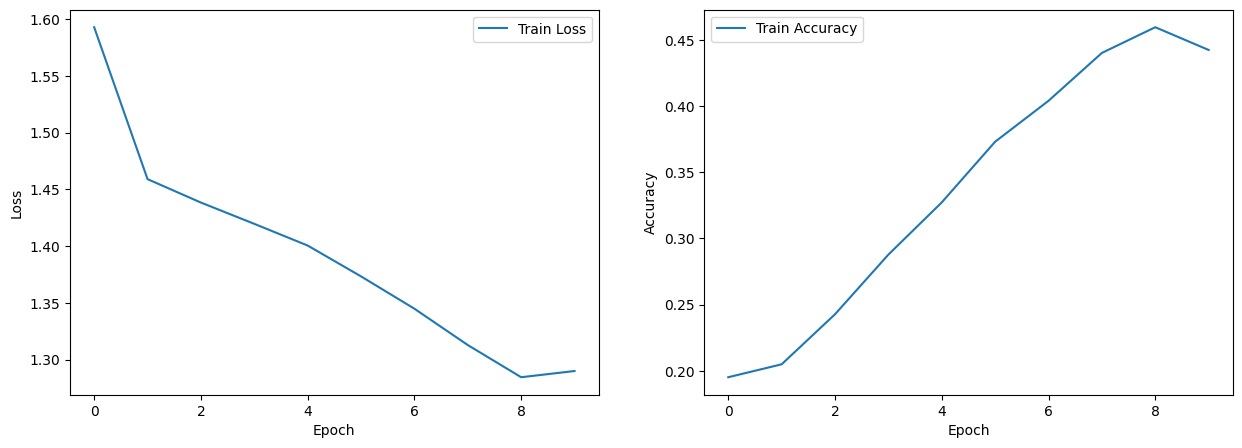


Training model 1


  0%|          | 0/10 [00:00<?, ?it/s]

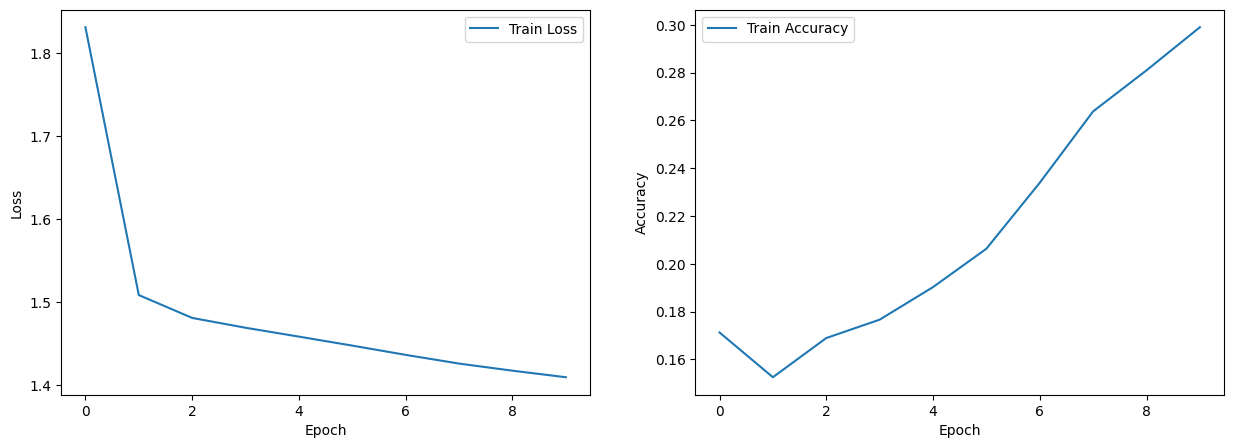


Training model 2


  0%|          | 0/10 [00:00<?, ?it/s]

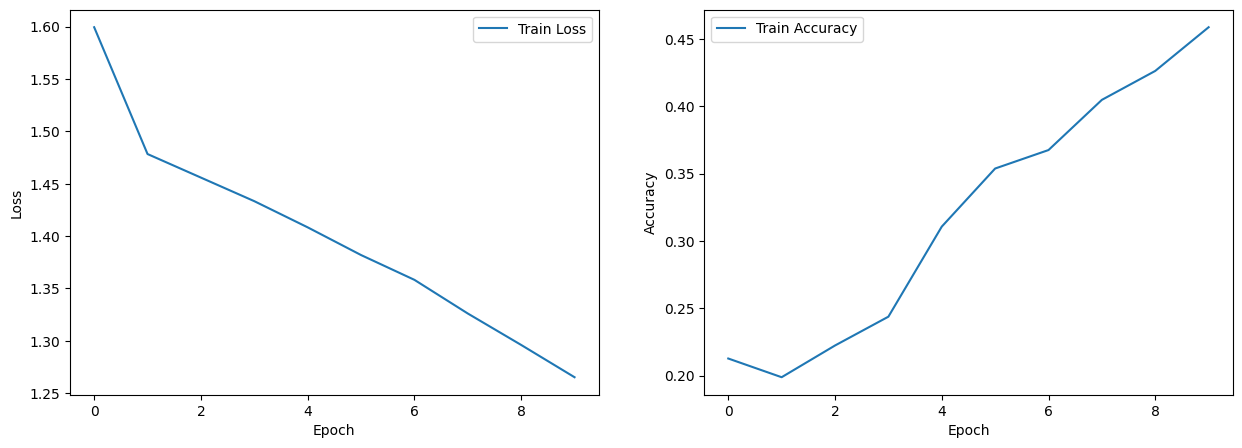


Training model 3


  0%|          | 0/10 [00:00<?, ?it/s]

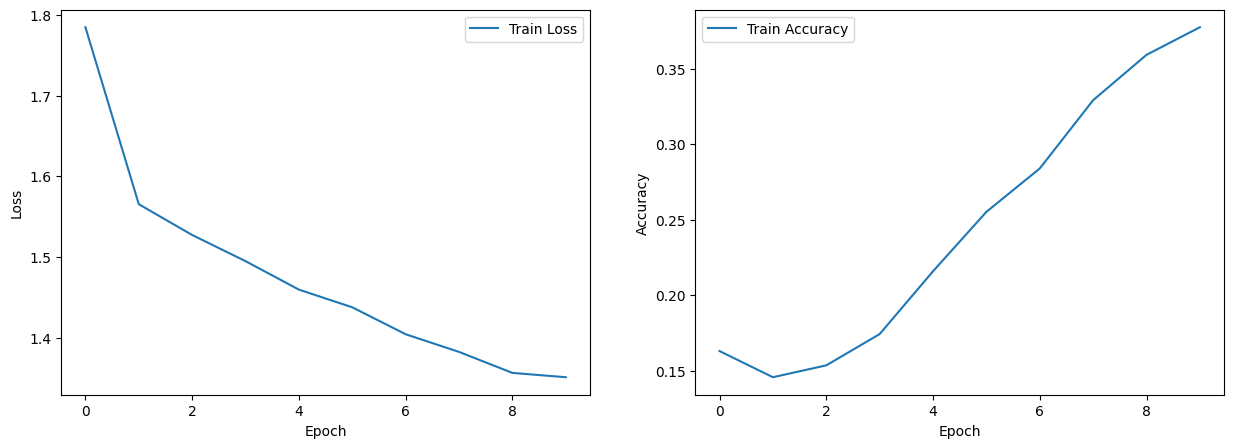


Training model 4


  0%|          | 0/10 [00:00<?, ?it/s]

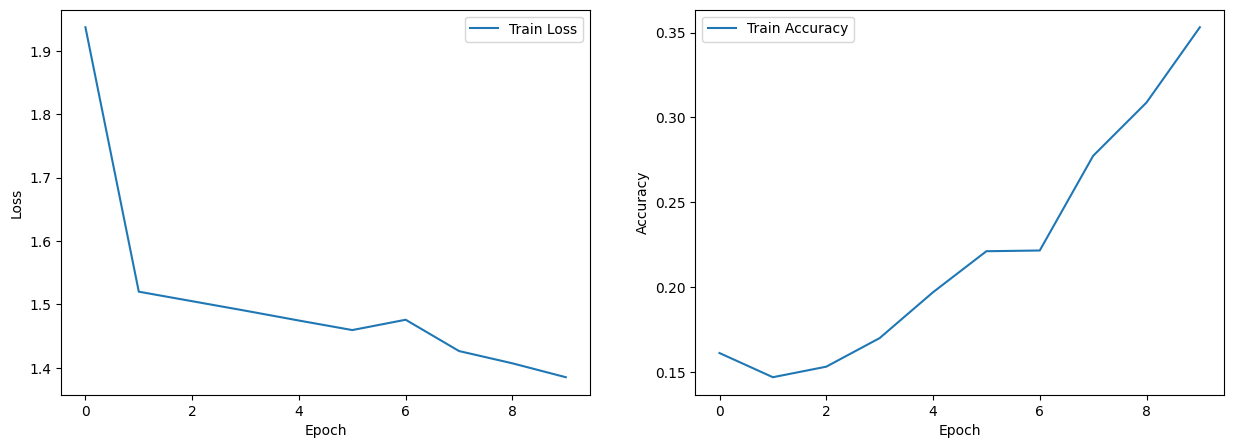


Training model 5


  0%|          | 0/10 [00:00<?, ?it/s]

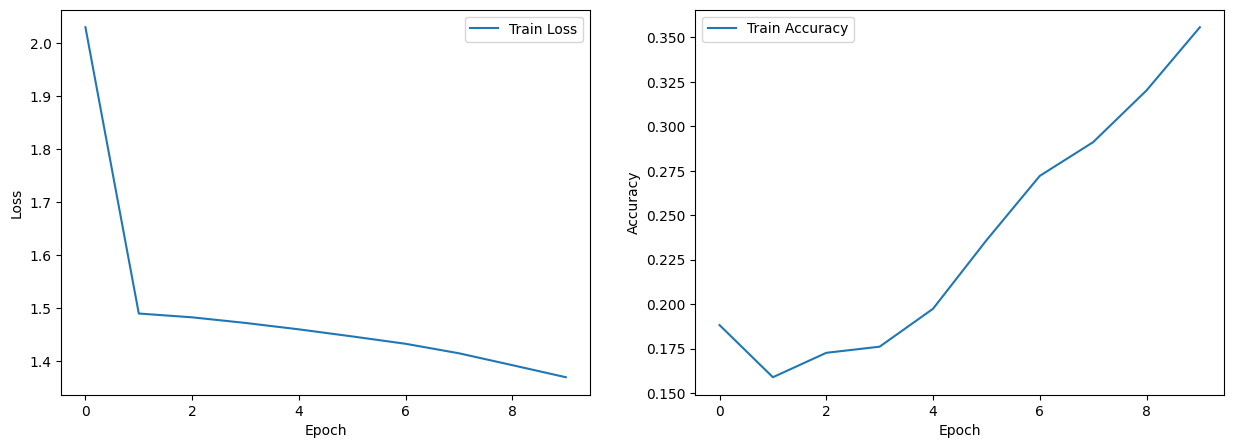


Training model 6


  0%|          | 0/10 [00:00<?, ?it/s]

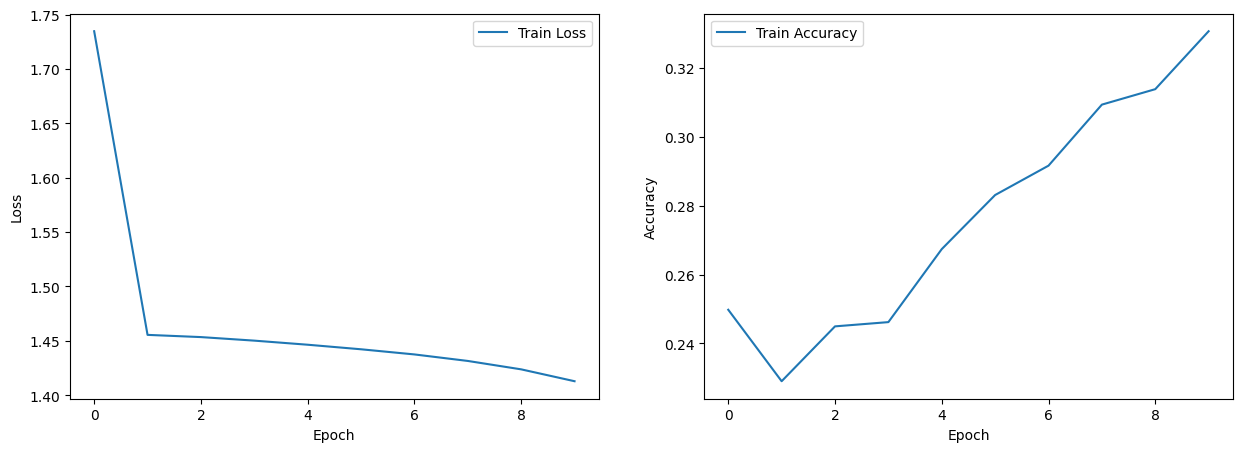

In [10]:
layer_sizes = [27, 64, 128, 32, 5]
for i in range(7):
    
    print(f"\nTraining model {i}")
    start, end = splits[i]
    train_dataset = CustomDataset(dataset[start:end])
    train_loader = DataLoader(train_dataset, batch_size=128)
    model = MLP(layer_sizes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.NLLLoss()
    train(model, criterion, optimizer, train_loader, epochs=10, verbose=False)

    torch.save(model, f"models/model_{i}.pt")

In [25]:
def weighted_majority_train():
    num_models = 7
    models = []
    weights = [1.0] * num_models
    a = 0
    b = 0

    for i in range(num_models):
        model = torch.load(f"models/model_{i}.pt", map_location=device)
        model.eval()
        models.append(model)

    train_dataset = CustomDataset(df)
    train_loader = DataLoader(train_dataset, batch_size=128)

    for input, labels in tqdm(train_loader):
        input, labels = input.to(device), labels.to(device)
        
        # for i in range(len(input)):
        for input_tensor, label in zip(input, labels):
            preds = torch.zeros(5, device=device)
            model_preds = {val: [] for val in range(5)}

            # for j in range(num_models):
            #     model = models[j]
            #     outputs = model(input[i].unsqueeze(0))
            #     _, predicted = torch.max(outputs, 1)
            #     preds.scatter_add_(0, predicted, torch.ones(1, device=device))
            #     model_preds[int(predicted)].append(j)

            for model in models:
                outputs = model(input_tensor.unsqueeze(0))
                _, predicted = torch.max(outputs, dim=1)
                preds.scatter_add_(0, predicted, torch.ones(1, device=device))
                model_preds[int(predicted)].append(models.index(model))

            prediction = preds.argmax().item()

            if prediction != label:
                for k in model_preds[int(label)]:
                    weights[k] *= 2
                    a+=1

                for l in range(5):
                    if l != label:
                        for m in model_preds[l]:
                            weights[m] /= 2
                            b+=1

    with open("weights.pkl", "wb") as f:
        pickle.dump(weights, f)

    print(a, b)
    return weights

In [26]:
weights = weighted_majority_train()

  0%|          | 0/488 [00:00<?, ?it/s]

59600 214135


In [22]:
def test(weights, data_loader):
    num_models = 7
    models = []
    for i in range(num_models):
        model = torch.load(f"models/model_{i}.pt", map_location=device)
        model.eval()
        models.append(model)

    corrects = 0
    for input, labels in tqdm(data_loader):
        input, labels = input.to(device), labels.to(device)

        # for i in range(len(input)):
        for input_tensor, label in zip(input, labels):
            preds = torch.zeros(5, device=device)

            # for j in range(num_models):
            #     model = models[j]
            #     output = model(input[i].unsqueeze(0))
            #     _, predicted = torch.max(output, dim=1)
            #     preds.scatter_add_(0, predicted, torch.tensor(weights[j], device=device))

            for model, weight in zip(models, weights):
                outputs = model(input_tensor.unsqueeze(0))
                _, predicted = torch.max(outputs, dim=1)
                preds.scatter_add_(0, predicted, torch.tensor(weight, device=device))

            prediction = preds.argmax().item()
            corrects += int(prediction == label)

    print(f"Accuracy: {corrects / len(test_df)}")

In [23]:
test_dataset = CustomDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=128)
test(weights, test_loader)

  0%|          | 0/488 [00:00<?, ?it/s]

Accuracy: 0.7557051282051283
